# Análisis de vuelos

In [1]:
import requests
from bs4 import BeautifulSoup
import pandas as pd
import time
import random
from datetime import datetime
import os

In [2]:
!pip install xlsxwriter
!pip install tabulate

   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 175.3/175.3 kB 8.4 MB/s eta 0:00:00


In [3]:
url = "https://failbondi.fail/?date="
headers = {
    "User-Agent": "Mozilla/5.0 (Windows NT 10.0; Win64; x64) AppleWebKit/537.36 (KHTML, like Gecko) Chrome/91.0.4472.124 Safari/537.36"
}

year = "2025"

months_max_days = { "01": 31, "02": 28, "03": 31, "04": 30, "05": 31, "06": 30, "07": 31, "08": 31, "09": 30, "10": 31, "11": 30, "12": 31 }
month_days = ["01", "02", "03", "04", "05", "06", "07", "08", "09", "10", "11","12","13","14","15","16","17","18","19","20", "21", "22", "23", "24", "25", "26", "27", "28", "29", "30", "31"]

In [4]:
def get_html_from_url(url, headers):
    response = requests.get(url, headers=headers)
    if response.status_code == 200:
        # Creamos un objeto BeautifulSoup para poder navegar por el HTML.
        soup = BeautifulSoup(response.content, "html.parser")
        return soup
    return None

def scraping_vuelos(html, fecha):
    # 1. Extraer encabezados
    headers = [th.text.strip() for th in html.find('thead').find_all('th')]

    # 2. Extraer filas
    rows = []
    table_body = html.find('tbody')
    for tr in table_body.find_all('tr'):
        cells = [td.text.strip() for td in tr.find_all('td')]
        rows.append(cells)

    # 3. Crear DataFrame para manipular fácilmente
    df = pd.DataFrame(rows, columns=headers)
    df['fecha'] = fecha
    df['fecha'] = pd.to_datetime(df['fecha'])

    # Extraer el mes (nombre o número) para agrupar
    df['mes'] = df['fecha'].dt.month

    return df


def get_report_by_month(year_month, max_days):
    lista_dfs = []
    for i in range(max_days):
        date = year_month + "-" + month_days[i]
        url_link = url + date
        main_content = get_html_from_url(url_link, headers)
        # Ejecutar la función
        try:
            df_iteracion = scraping_vuelos(main_content, date)
            lista_dfs.append(df_iteracion)
        except Exception as e:
            print(f"Error en fecha {date}: {e}")


    df_month = pd.concat(lista_dfs, ignore_index=True)
    print(f"[{year_month}] - Filas obtenidas: {len(df_month)}")
    time.sleep(random.uniform(2, 5))
    print(df_month.head(5))
    return df_month


In [7]:
lista_dfs = []


for month, max_days in months_max_days.items():
    year_month = year + "-" + month
    inicio_peticion = time.time()
    lista_dfs.append(get_report_by_month(year_month, max_days))

    fin_peticion = time.time()
    duracion = fin_peticion - inicio_peticion
    hora_actual = datetime.now().strftime('%H:%M:%S')

    print(f"[{hora_actual}] Finalizado: {year_month} | Tiempo: {duracion:.2f}s")

[2025-01] - Filas obtenidas: 2205
     Vuelo                         Ruta Hora Programada Hora Real  \
0  FO 5912  Aeroparque → Rio de Janeiro           13:05             
1  FO 5237       Bariloche → Aeroparque           07:50     19:22   
2  FO 5236           Ezeiza → Bariloche           05:00     15:16   
3  FO 5027             Córdoba → Ezeiza           20:40  02:18 +1   
4  FO 5056         Aeroparque → Mendoza           16:00     21:27   

  Demora en despegar      fecha  mes  
0          Cancelado 2025-01-01    1  
1   11hs 32min tarde 2025-01-01    1  
2   10hs 16min tarde 2025-01-01    1  
3    5hs 38min tarde 2025-01-01    1  
4    5hs 27min tarde 2025-01-01    1  
[18:25:45] Finalizado: 2025-01 | Tiempo: 30.66s
[2025-02] - Filas obtenidas: 1880
     Vuelo                  Ruta Hora Programada Hora Real Demora en despegar  \
0  FO 5069  Mendoza → Aeroparque           21:59                    Cancelado   
1  FO 5055      Mendoza → Ezeiza           20:55                    Cance

In [8]:
def exportar_datos(lista_maestra, nombre_archivo, formato='csv'):
    """
    Exporta una lista de listas a CSV o Excel.

    :param lista_maestra: La data a guardar.
    :param nombre_archivo: Nombre del archivo (sin extensión).
    :param formato: 'csv' o 'excel'.
    """
    # Convertimos la lista a un DataFrame de Pandas
    #lista_plana = [registro for sublista in lista_maestra for registro in sublista]
    df_year = pd.concat(lista_maestra, ignore_index=True)
    print(df_year[:10])
    # Usaremos 'vuelo', ya que es la primera columna
    columna_referencia = 'Vuelo'

    # 3. Filtramos: Mantenemos solo las filas donde el valor NO sea igual al nombre del encabezado
    df_limpio = df_year[df_year[columna_referencia] != columna_referencia]
    df = pd.DataFrame(df_limpio)
    ruta = ''

    try:
        if formato.lower() == 'csv':
            ruta = f"{nombre_archivo}.csv"
            df.to_csv(ruta, index=False, encoding='utf-8-sig')
            print(f"✅ Archivo CSV guardado como: {ruta}")

        elif formato.lower() == 'excel':
            ruta = f"{nombre_archivo}.xlsx"
            df.to_excel(ruta, index=False, engine='openpyxl')
            print(f"✅ Archivo Excel guardado como: {ruta}")

        else:
            print("❌ Formato no soportado. Usa 'csv' o 'excel'.")

    except Exception as e:
        print(f"Error al exportar: {e}")
    else:
        return ruta

ruta_archivo = exportar_datos(lista_dfs, "reporte_final_anual", formato='csv')
file_size = os.path.getsize(ruta_archivo)

print(f"\n¡Éxito! El archivo '{ruta_archivo}' ha sido creado. Tamaño: {file_size} bytes")

     Vuelo                         Ruta Hora Programada Hora Real  \
0  FO 5912  Aeroparque → Rio de Janeiro           13:05             
1  FO 5237       Bariloche → Aeroparque           07:50     19:22   
2  FO 5236           Ezeiza → Bariloche           05:00     15:16   
3  FO 5027             Córdoba → Ezeiza           20:40  02:18 +1   
4  FO 5056         Aeroparque → Mendoza           16:00     21:27   
5  FO 5057         Mendoza → Aeroparque           18:25     23:44   
6  FO 5472            Córdoba → Neuquen           16:15     21:01   
7  FO 5272           Ezeiza → Bariloche           12:55     16:13   
8  FO 5016         Aeroparque → Córdoba           15:45     19:01   
9  FO 5061             Mendoza → Ezeiza           21:30  00:26 +1   

  Demora en despegar      fecha  mes  
0          Cancelado 2025-01-01    1  
1   11hs 32min tarde 2025-01-01    1  
2   10hs 16min tarde 2025-01-01    1  
3    5hs 38min tarde 2025-01-01    1  
4    5hs 27min tarde 2025-01-01    1  
5    5

_____
# Reporte

In [80]:
def read_csv_file(path):
    df = pd.read_csv(path)
    return df

def imprimir_reporte(titulo, datos):
    ancho = max(len(titulo), 25) # Ajusta el ancho mínimo a 25 o al largo del título
    print("=" * 40)
    print(titulo.upper())
    print("-" * ancho)
    print(datos)
    print("=" * 40)


def basic_info_df(df):
    print("=" * 40)
    print("Report")

    imprimir_reporte("Shape:", f"Columns: {df.shape[1]}\t|\tRows: {df.shape[0]}")
    imprimir_reporte("Info", df.info())

    print_df(df.describe().T)

    imprimir_reporte("Null values count:", df.isnull().sum())

    imprimir_reporte("Unique values:", df.nunique())


def print_df(df_desc):
    from tabulate import tabulate

    # 'headers' son las columnas (count, mean, std, etc.)
    # 'tablefmt' puede ser "grid", "fancy_grid", "pipe" o "psql"
    print(tabulate(df_desc, headers='keys', tablefmt='psql'))

In [81]:
df = read_csv_file("reporte_final_anual.csv")
basic_info_df(df)

Report
SHAPE:
-------------------------
Columns: 7	|	Rows: 20186
<class 'pandas.core.frame.DataFrame'>
RangeIndex: 20186 entries, 0 to 20185
Data columns (total 7 columns):
 #   Column              Non-Null Count  Dtype 
---  ------              --------------  ----- 
 0   Vuelo               20186 non-null  object
 1   Ruta                20186 non-null  object
 2   Hora Programada     20186 non-null  object
 3   Hora Real           18909 non-null  object
 4   Demora en despegar  20186 non-null  object
 5   fecha               20186 non-null  object
 6   mes                 20186 non-null  int64 
dtypes: int64(1), object(6)
memory usage: 1.1+ MB
INFO
-------------------------
None
+-----+---------+---------+---------+-------+-------+-------+-------+-------+
|     |   count |    mean |     std |   min |   25% |   50% |   75% |   max |
|-----+---------+---------+---------+-------+-------+-------+-------+-------|
| mes |   20186 | 6.34648 | 3.62318 |     1 |     3 |     6 |    10 |    12

## Valores nulos
En la columna de "Hora Real" se encuentran más de mil valores nulos, esto es debido a que si existen vuelos cancelados, no existe el valor.

In [82]:
df.describe().T

,count,mean,std,min,25%,50%,75%,max
mes,20186.0,6.346478,3.623177,1.0,3.0,6.0,10.0,12.0


## Limpieza de datos

Transformación de datos


In [83]:
import pandas as pd
import re

def transformar_demoras(df, columna_nombre):
    def procesar_fila(valor):
        valor = str(valor).lower().strip()

        # 1. Caso: Cancelado
        if 'cancelado' in valor:
            return None, 'Cancelled'

        # 2. Caso: A tiempo
        if 'a tiempo' in valor:
            return 0, 'On time'

        # Extraer números de horas y minutos
        # Buscamos un número seguido de 'h' y un número seguido de 'm'
        horas_match = re.search(r'(\d+)\s*hs?', valor)
        minutos_match = re.search(r'(\d+)\s*min', valor)

        horas = int(horas_match.group(1)) if horas_match else 0
        minutos = int(minutos_match.group(1)) if minutos_match else 0

        total_minutos = int((horas * 60) + minutos)

        # 3. Caso: Adelantado (Valor negativo)
        if 'adelantado' in valor:
            return -total_minutos, 'Early'

        # 4. Caso: Tarde (Delayed)
        if 'tarde' in valor or total_minutos > 0:
            return total_minutos, 'Delayed'

        return 0, 'On time'

    # Aplicamos la lógica y expandimos en dos columnas nuevas
    resultados = df[columna_nombre].apply(procesar_fila)
    df[['minutos_netos_demora', 'status']] = pd.DataFrame(resultados.tolist(), index=df.index)

    return df


/tmp/ipython-input-557021792.py:45: UserWarning: Could not infer format, so each element will be parsed individually, falling back to `dateutil`. To ensure parsing is consistent and as-expected, please specify a format.
  df['Hora Programada'] = pd.to_datetime(df['Hora Programada'], errors='coerce')


In [95]:
df_transformado = transformar_demoras(df, 'Demora en despegar')
df_transformado['is_cancelled'] = df_transformado['Demora en despegar'].str.contains('Cancelado', na=False, case=False)
df_transformado['Hora Programada'] = pd.to_datetime(df_transformado['Hora Programada'], errors='coerce')

# Extraemos solo la hora (0-23) para agrupar
df_transformado['franja_horaria'] = df_transformado['Hora Programada'].dt.hour

print(df_transformado)

         Vuelo                         Ruta     Hora Programada Hora Real  \
0      FO 5912  Aeroparque → Rio de Janeiro 2026-01-29 13:05:00       NaN   
1      FO 5237       Bariloche → Aeroparque 2026-01-29 07:50:00     19:22   
2      FO 5236           Ezeiza → Bariloche 2026-01-29 05:00:00     15:16   
3      FO 5027             Córdoba → Ezeiza 2026-01-29 20:40:00  02:18 +1   
4      FO 5056         Aeroparque → Mendoza 2026-01-29 16:00:00     21:27   
...        ...                          ...                 ...       ...   
20181  FO 5954       Ezeiza → Florianopolis 2026-01-29 08:05:00     08:22   
20182  FO 5210             Ezeiza → Tucuman 2026-01-29 07:00:00     07:16   
20183  FO 5091             Posadas → Ezeiza 2026-01-29 14:25:00     14:40   
20184  FO 5103          Iguazú → Aeroparque 2026-01-29 05:35:00     05:45   
20185  FO 5102          Aeroparque → Iguazú 2026-01-29 03:15:00     03:17   

      Demora en despegar       fecha  mes  is_cancelled  franja_horaria  \


In [85]:
# Crear categorías lógicas
bins = [-float('inf'), 0, 15, 60, 180, float('inf')]
labels = ['A tiempo/Adelantado', 'Demora Leve (0-15m)', 'Demora Media (15-60m)', 'Demora Grave (1-3h)', 'Crítico (>3h)']

df_transformado['categoria_demora'] = pd.cut(df_transformado['minutos_netos_demora'], bins=bins, labels=labels)

In [86]:
df_transformado[ "status" ].value_counts()


,count
status,
Delayed,18052
Cancelled,1278
Early,668
On time,188


In [87]:
df_transformado.head(5)

,Vuelo,Ruta,Hora Programada,Hora Real,Demora en despegar,fecha,mes,is_cancelled,franja_horaria,minutos_netos_demora,status,categoria_demora
0,FO 5912,Aeroparque → Rio de Janeiro,2026-01-29 13:05:00,NaN,Cancelado,2025-01-01,1,True,13,NaN,Cancelled,NaN
1,FO 5237,Bariloche → Aeroparque,2026-01-29 07:50:00,19:22,11hs 32min tarde,2025-01-01,1,False,7,692.0,Delayed,Crítico (>3h)
2,FO 5236,Ezeiza → Bariloche,2026-01-29 05:00:00,15:16,10hs 16min tarde,2025-01-01,1,False,5,616.0,Delayed,Crítico (>3h)
3,FO 5027,Córdoba → Ezeiza,2026-01-29 20:40:00,02:18 +1,5hs 38min tarde,2025-01-01,1,False,20,338.0,Delayed,Crítico (>3h)
4,FO 5056,Aeroparque → Mendoza,2026-01-29 16:00:00,21:27,5hs 27min tarde,2025-01-01,1,False,16,327.0,Delayed,Crítico (>3h)


In [88]:
import matplotlib.pyplot as plt

def graficar_frecuencias(df, columna, titulo=None, color='deeppink', ordenar_por_indice=True):
    """
    Genera un gráfico de barras ordenado.
    ordenar_por_indice=True: Ordena por categorías (ej. Mes 1, 2, 3).
    ordenar_por_indice=False: Ordena por frecuencia (el más común primero).
    """
    # 1. Preparación de datos
    counts = df[columna].value_counts()

    if ordenar_por_indice:
        counts = counts.sort_index()

    # 2. Creación del gráfico
    plt.figure(figsize=(8, 4))
    # Usamos counts.index para el eje X y counts.values para el Y
    plt.bar(counts.index.astype(str), counts.values, color=color)

    # 3. Estética y etiquetas
    plt.title(titulo if titulo else f'Distribución de {columna}', fontsize=14)
    plt.xlabel(columna, fontsize=12)
    plt.ylabel('Cantidad de Registros', fontsize=12)
    plt.xticks(rotation=45)
    plt.grid(axis='y', linestyle='--', alpha=0.7)

    plt.tight_layout()
    plt.show()

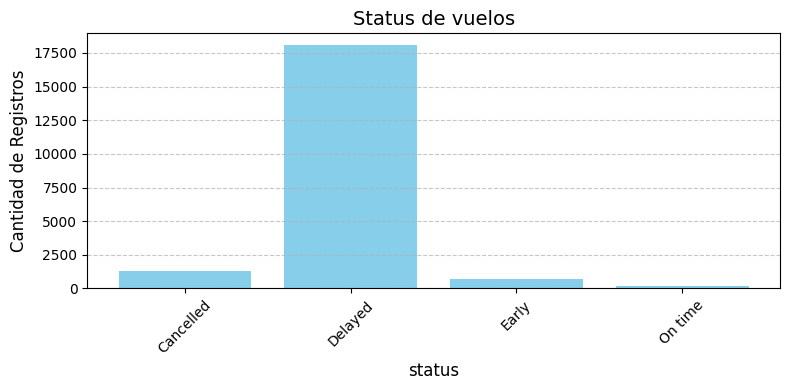

In [89]:
graficar_frecuencias(df_transformado, 'status', titulo='Status de vuelos', color='skyblue')


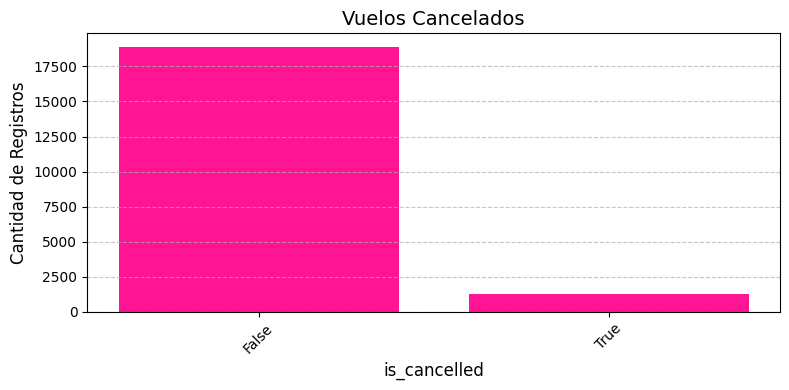

In [90]:
graficar_frecuencias(df_transformado, 'is_cancelled', titulo='Vuelos Cancelados')


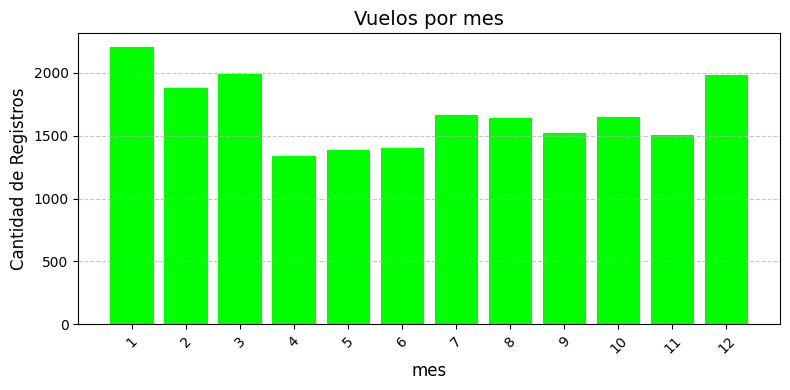

In [91]:
graficar_frecuencias(df_transformado, 'mes', titulo='Vuelos por mes', color="lime")


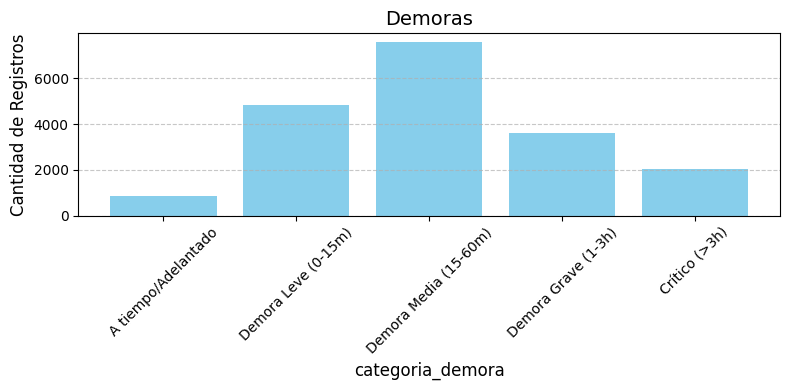

In [92]:
graficar_frecuencias(df_transformado, 'categoria_demora', titulo='Demoras', color="skyblue")


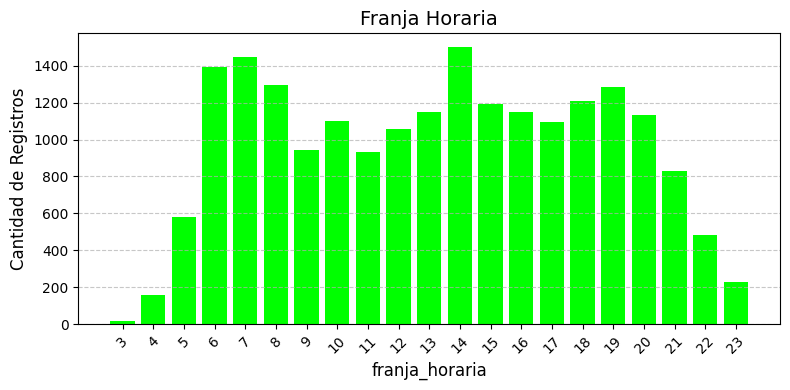

In [97]:
graficar_frecuencias(df_transformado, 'franja_horaria', titulo='Franja Horaria', color="lime")


In [93]:
resumen = {
    'Promedio de demora': df['minutos_netos_demora'].mean(),
    'Mediana (el valor real típico)': df['minutos_netos_demora'].median(),
    'Vuelo más demorado': df['minutos_netos_demora'].max(),
    'Total de vuelos cancelados': df['minutos_netos_demora'].isna().sum()
}
print(resumen)

{'Promedio de demora': np.float64(71.56425851491433), 'Mediana (el valor real típico)': 30.0, 'Vuelo más demorado': 1349.0, 'Total de vuelos cancelados': np.int64(1278)}


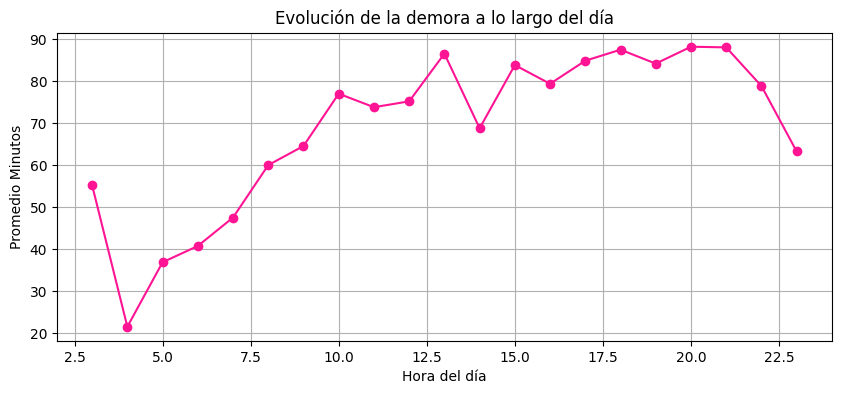

In [96]:
demora_por_hora = df_transformado.groupby('franja_horaria')['minutos_netos_demora'].mean()

# Graficamos
demora_por_hora.plot(kind='line', marker='o', color='deeppink', figsize=(10,4))
plt.title('Evolución de la demora a lo largo del día')
plt.xlabel('Hora del día')
plt.ylabel('Promedio Minutos')
plt.grid(True)
plt.show()

In [100]:
# 1. Sumamos todos los minutos de demora (ignorando los NaN automáticamente)
total_minutos = df['minutos_netos_demora'].sum()

# 2. Conversiones
total_horas = total_minutos / 60
total_dias = total_minutos / 1440 # 1440 min tiene un día

print(f"--- IMPACTO TOTAL DE LAS DEMORAS ---")
print(f"Tiempo total perdido: {total_minutos:,.0f} minutos")
print(f"Equivalente a: {total_horas:,.1f} horas")
print(f"Equivalente a: {total_dias:,.2f} días completos de espera")

total_anios = total_dias / 365
if total_anios > 1:
  print(f"Equivalente a: {total_anios:,.2f} años completos de espera")


--- IMPACTO TOTAL DE LAS DEMORAS ---
Tiempo total perdido: 1,353,137 minutos
Equivalente a: 22,552.3 horas
Equivalente a: 939.68 días completos de espera
Equivalente a: 2.57 años completos de espera


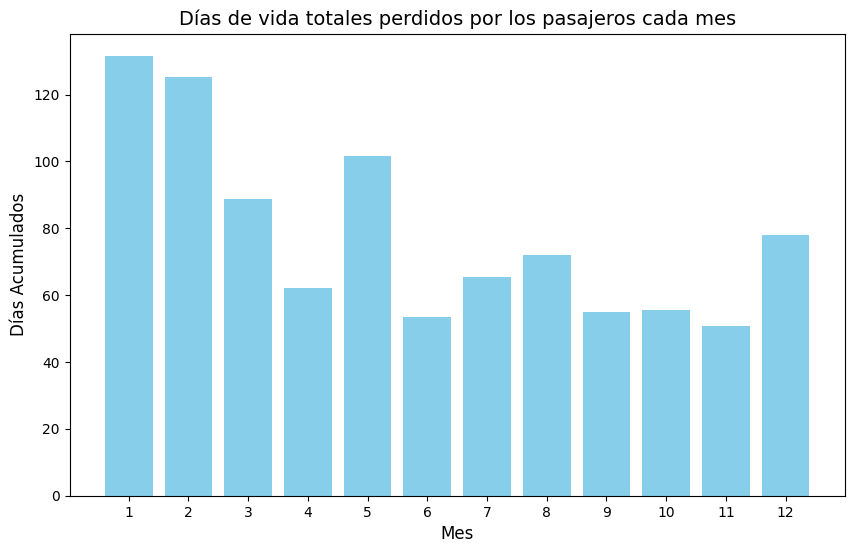

In [99]:
# Agrupamos la suma de minutos por mes y convertimos a días
dias_por_mes = df.groupby('mes')['minutos_netos_demora'].sum() / 1440

# Gráfico de barras
plt.figure(figsize=(10, 6))
plt.bar(dias_por_mes.index.astype(str), dias_por_mes.values, color='skyblue')
plt.title('Días de vida totales perdidos por los pasajeros cada mes', fontsize=14)
plt.ylabel('Días Acumulados', fontsize=12)
plt.xlabel('Mes', fontsize=12)
plt.show()